# Mapping gene expression in space with moscot

In this tutorial, we show how to use moscot `moscot.problems.space.MappingProblem` for transferring gene expression from single cell data to spatial data.

Mapping single-cell atlases to spatial transcriptomics data is a crucial analysis steps to integrate cell-type annotation across technologies. 
Furthermore, it is often the case that imaging-based spatial transcriptomics technologies only measure a limit set of transcripts, which could be nonetheless used as anchor features to map the gene expression of unobserved genes from single cell data.

For this purpose, we will use a pre-processed and normalized dataset of the Drosophila Embryo, originally used in **novosparc** <cite data-cite="nitzan:19">Nitzan et al. (2019)</cite>. In fact, moscot `MappingProblem` is essentially a re-implementation of the original Gromov-Wasserstein formulation from **novosparc**, yet with a some of technical innovations that makes it more scalable. 

For this tutorial, you will also need the package `squidpy` for spatial data plotting. You can either install it with `pip install squidpy` or simply install `moscot` with `squidpy` as an optional dependency `pip install moscot[spatial]`.

First, let's import some libraries.

In [1]:
import squidpy as sq
import moscot as mt
import scanpy as sc

%load_ext autoreload
%autoreload 2
%load_ext lab_black

sc.logging.print_header()
print(f"moscot=={mt.__version__}")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7
moscot==0.1


We will load the public data available in moscot.

In [2]:
from moscot.datasets import drosophila_sc, drosophila_sp

adata_sc = drosophila_sc()
adata_sp = drosophila_sp()

/Users/giovanni.palla/.cache/moscot/datasets/adata_dm_sc.h5ad
/Users/giovanni.palla/.cache/moscot/datasets/adata_dm_sp.h5ad


Let's take a look at the data by plotting couple of summary statistics.

The single-cell data contains: 1297 cells and 2000 genes.


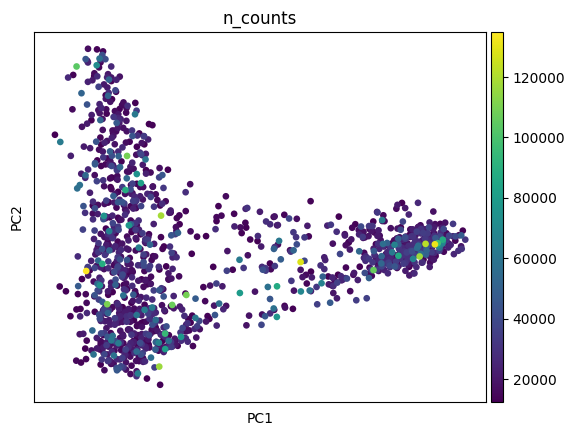

The spatial data contains: 3039 cells and 82 genes.


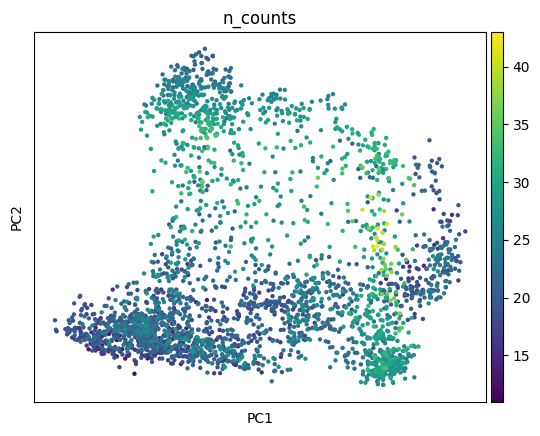

In [3]:
print(
    f"The single-cell data contains: {len(adata_sc)} cells and {adata_sc.shape[1]} genes."
)
sc.pl.pca(adata_sc, color="n_counts")
print(
    f"The spatial data contains: {len(adata_sp)} cells and {adata_sp.shape[1]} genes."
)
sc.pl.pca(adata_sp, color="n_counts")

We can also visualize the spatial dataset in spatial coordinates. Here, it's important to consider that the spatial datasets actually consists of measurements in 3D.
We can visualize them with scanpy, as well as with squidpy in 2D.

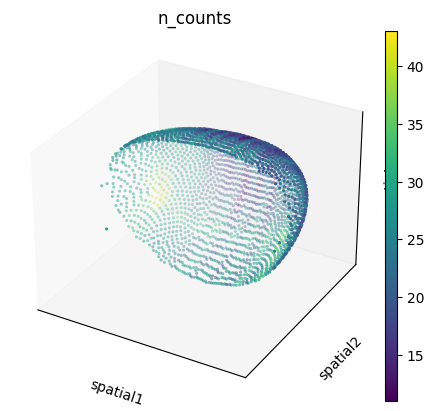

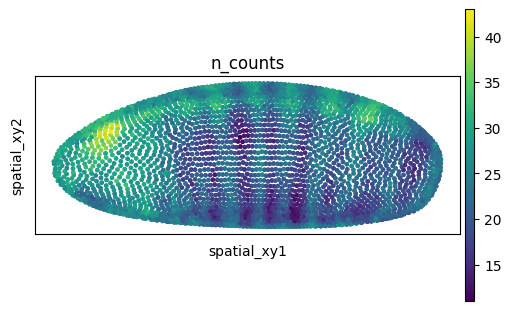

In [4]:
sc.pl.embedding(
    adata_sp,
    basis="spatial",
    color="n_counts",
    projection="3d",
    na_color=(1, 1, 1, 0),
)
adata_sp.obsm["spatial_xy"] = adata_sp.obsm["spatial"][:, [0, 2]]
sq.pl.spatial_scatter(
    adata_sp,
    spatial_key="spatial_xy",
    color="n_counts",
    shape=None,
    size=20,
    figsize=(5, 3),
)

## Mapping single cell gene expression in space with moscot `MappingProblem`
With moscot, it is possible to learn a single-cell-to-spatial mapping by leveraging Fused-Gromov-Wasserstein (FGW) Optimal Transport. A basic description of the algorithm is the following:

Given a set of observations that share some features in the metric space, and some other features in different metric spaces, the FGW method aims at finding the optimal matching between these two set of observations, based on both shared and unique features.

In our case, the "shared" metric space could be the one defined by a set of genes that were measured in both single cell and spatial transcriptomics data. On the other hand, the "unique" metric spaces are:
- the genes only measured in single-cell data
- the spatial coordinates for the spatial transcriptomics data

The moscot `MappingProblem` interfaces the FGW algorithm to the user in a friendly API that is the following.
First, let's initialize the problem and take a look at the arguments. To be initialized, the `MappingProblem` only requires the two `AnnData` objects.

In [5]:
from moscot.problems.space import MappingProblem

mp = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp)

After initialization, we need to "prepare" the problem. In this particular case, we need to pay attention to 3 arguments:
- `sc_attr`: specify the slot in AnnData that we want to use for the features (genes) in the unique space. Usually, it's the `adata.X` slot, which contains normalized counts, but a pre-computed PCA could also be used.
  Furthermore, for the `unique` features it might be desirable to use some other type of modality, for instance protein expression or ATAC-seq measurements, that could be stored for example in `adata.obsm`.
- `var_names`: specify the set of genes that we desire to be using for the `shared` space, that is the common set of genes in both dataset. If set to `None`, it will try to compute the intersection between
  the single cell and spatial gene names.
- `joint_attr`: it is possible to also specify some other attributes that might be used for the "shared" features space, for instance, an embedding such as PCA.

If the number of shared features is large enough, it is also possible to compute a PCA on the "shared" gene space (by passing the "callback_kwargs"). This is what we advise if we are in the settings of >50 genes shared between the two datasets.

We will now go ahead and prepare the problem with the following parameters:

In [6]:
mp = mp.prepare(
    sc_attr={"attr": "obsm", "key": "X_pca"}, kwargs={"callback_kwargs": "local_pca"}
)

INFO     Computing pca with `n_comps=30` using `adata.X`                                                           


We are now ready to "solve" the problem. The most important argument to take into consideration is the `alpha` value, which balances the weight of each loss ("unique" v. "shared" spaces). With alpha close to 0, the "shared" space loss is weighted more, with alpha close to 1, the "unique" space loss is balanced more. For the purpose of this example, we'll use `alpha=0.5` but we suggest to increase if only a few features are present. It should take maximum one minute on a laptop. We can then explore the results.

In [7]:
mp = mp.solve()

INFO     Solving problem OTProblem[stage='prepared', shape=(3039, 1297)].                                          


## Analysis of the resulting transport map

The first thing we might be interested in doing, is "imputing" genes that were not present in the spatial data. We can do so by using the `impute` method.  If you are working on a GPU with large data, you might want to pass `decide="cpu"` to the method in order to use the CPU memory for this task. For the purpose of the tutorial, we will select few genes from the single cell data.

In [8]:
genes = ["cic", "jigr1", "nuse", "scb", "chrb"]
adata_imputed = mp.impute(var_names=genes)

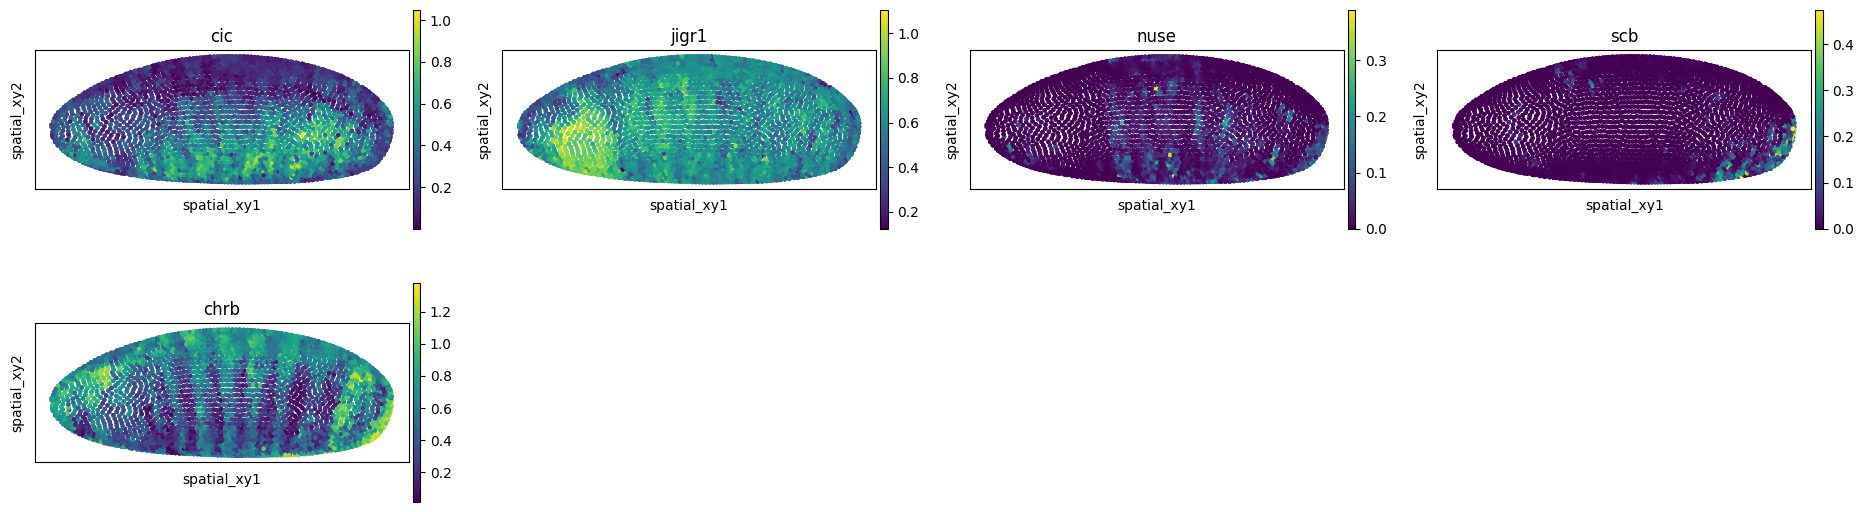

In [9]:
sq.pl.spatial_scatter(
    adata_imputed,
    spatial_key="spatial_xy",
    color=genes,
    shape=None,
    size=20,
    figsize=(5, 3),
)

Another analysis function that we provide is computing gene expression correlation between inferred and ground-truth spatial genes. We can do this with the `correlate` method.

In [10]:
corr = mp.correlate()
corr[("src", "tgt")]

tsh             0.709859
CenG1A          0.427544
brk             0.608453
kni             0.503961
cad             0.530226
                  ...   
exex            0.386143
E(spl)m5-HLH    0.269590
Mdr49           0.726613
Blimp-1         0.631301
Traf4           0.550105
Length: 82, dtype: float64